## SF Crime Data Analysis with PySpark

In this notebook we use PySpark to explore a dataset from the San Francisco Police Department.
Dataset link: [https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data](https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data)

In [10]:
import pyspark
print(pyspark.__version__)

# Create a SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SF Crime Analysis").getOrCreate()
sc = spark.sparkContext
print('SparkSession started')

3.5.4
SparkSession started


In [8]:
# Read the CSV data using an RDD
from csv import reader

# Read all lines from the CSV file
crime_data_lines = sc.textFile('sf_crime.csv')

# Convert each line to a list of strings (removing extra quotes)
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])

In [9]:
!pip install pyspark
# Extract header and filter it out
header = df_crimes.first()
print("Header:", header)
crimes = df_crimes.filter(lambda x: x != header)
print("First two data rows:", crimes.take(2))

Header: ['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId']
First two data rows: [['179005317', 'OTHER OFFENSES', 'FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY', 'Tuesday', '07/11/2017', '14:32', 'SOUTHERN', 'NONE', '800 Block of BRYANT ST', '-122.40340479147905', '37.775420706711', '(37.775420706711, -122.40340479147905)', '17900531709029'], ['179005210', 'FORGERY/COUNTERFEITING', 'MANUFACTURE OR SALE OF COUNTERFEIT GOODS', 'Tuesday', '07/11/2017', '17:27', 'SOUTHERN', 'NONE', '800 Block of BRYANT ST', '-122.40340479147905', '37.775420706711', '(37.775420706711, -122.40340479147905)', '17900521009261']]


In [12]:
# Convert the RDD of lists to an RDD of Rows
from pyspark.sql import Row

def list_to_row(keys, values):
    row_dict = dict(zip(keys, values))
    return Row(**row_dict)

rdd_rows = crimes.map(lambda x: list_to_row(header, x))
df = spark.createDataFrame(rdd_rows)
print("DataFrame created")

DataFrame created


In [13]:
# Show the DataFrame (first 20 rows)
df.show()

+----------+--------------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+
|IncidntNum|            Category|            Descript|DayOfWeek|      Date| Time|PdDistrict|    Resolution|             Address|                  X|                 Y|            Location|          PdId|
+----------+--------------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+
| 179005317|      OTHER OFFENSES|FALSE PERSONATION...|  Tuesday|07/11/2017|14:32|  SOUTHERN|          NONE|800 Block of BRYA...|-122.40340479147905|   37.775420706711|(37.775420706711,...|17900531709029|
| 179005210|FORGERY/COUNTERFE...|MANUFACTURE OR SA...|  Tuesday|07/11/2017|17:27|  SOUTHERN|          NONE|800 Block of BRYA...|-122.40340479147905|   37.775420706711|(37.775420706711,

In [14]:
# Replace columns 'X' and 'Y' with 'Longitude' and 'Latitude' and cast them as float
df = df.withColumn('X', df['X'].cast('float')).withColumn('Y', df['Y'].cast('float'))
df = df.withColumnRenamed('X', 'Longitude').withColumnRenamed('Y', 'Latitude')
print("Columns renamed and cast")

Columns renamed and cast


In [15]:
# Inspect the schema
df.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Location: string (nullable = true)
 |-- PdId: string (nullable = true)



### Exploring the Data

Let's count the number of incidents for each category.

In [16]:
# Method 1: Using Spark SQL
df.createOrReplaceTempView("crime")
sqlDF = spark.sql("""
    SELECT Category, COUNT(*) AS Count
    FROM crime
    GROUP BY Category
    ORDER BY Count DESC
""")
sqlDF.show(40, False)

+---------------------------+-----+
|Category                   |Count|
+---------------------------+-----+
|LARCENY/THEFT              |2804 |
|OTHER OFFENSES             |1002 |
|NON-CRIMINAL               |988  |
|ASSAULT                    |780  |
|VANDALISM                  |650  |
|VEHICLE THEFT              |353  |
|SUSPICIOUS OCC             |311  |
|WARRANTS                   |309  |
|BURGLARY                   |300  |
|MISSING PERSON             |263  |
|ROBBERY                    |187  |
|DRUG/NARCOTIC              |167  |
|FRAUD                      |155  |
|SECONDARY CODES            |118  |
|TRESPASS                   |109  |
|WEAPON LAWS                |106  |
|STOLEN PROPERTY            |66   |
|RECOVERED VEHICLE          |48   |
|SEX OFFENSES, FORCIBLE     |39   |
|RUNAWAY                    |39   |
|ARSON                      |29   |
|FORGERY/COUNTERFEITING     |29   |
|PROSTITUTION               |20   |
|DRUNKENNESS                |19   |
|DISORDERLY CONDUCT         

In [ ]:
# Method 2: Using DataFrame functions
df.groupBy("Category").count().orderBy("count", ascending=False).show(40, False)

+---------------------------+-----+
|Category                   |count|
+---------------------------+-----+
|LARCENY/THEFT              |2804 |
|OTHER OFFENSES             |1002 |
|NON-CRIMINAL               |988  |
|ASSAULT                    |780  |
|VANDALISM                  |650  |
|VEHICLE THEFT              |353  |
|SUSPICIOUS OCC             |311  |
|WARRANTS                   |309  |
|BURGLARY                   |300  |
|MISSING PERSON             |263  |
|ROBBERY                    |187  |
|DRUG/NARCOTIC              |167  |
|FRAUD                      |155  |
|SECONDARY CODES            |118  |
|TRESPASS                   |109  |
|WEAPON LAWS                |106  |
|STOLEN PROPERTY            |66   |
|RECOVERED VEHICLE          |48   |
|SEX OFFENSES, FORCIBLE     |39   |
|RUNAWAY                    |39   |
|ARSON                      |29   |
|FORGERY/COUNTERFEITING     |29   |
|PROSTITUTION               |20   |
|DRUNKENNESS                |19   |
|DISORDERLY CONDUCT         

In [ ]:
# Method 3: Using RDD functions
rdd = crimes.map(lambda line: (line[1], 1))
sorted_counts = sorted(rdd.countByKey().items(), key=lambda x: -x[1])
print(sorted_counts)

[('LARCENY/THEFT', 2804), ('OTHER OFFENSES', 1002), ('NON-CRIMINAL', 988), ('ASSAULT', 780), ('VANDALISM', 650), ('VEHICLE THEFT', 353), ('SUSPICIOUS OCC', 311), ('WARRANTS', 309), ('BURGLARY', 300), ('MISSING PERSON', 263), ('ROBBERY', 187), ('DRUG/NARCOTIC', 167), ('FRAUD', 155), ('SECONDARY CODES', 118), ('TRESPASS', 109), ('WEAPON LAWS', 106), ('STOLEN PROPERTY', 66), ('RECOVERED VEHICLE', 48), ('SEX OFFENSES, FORCIBLE', 39), ('RUNAWAY', 39), ('FORGERY/COUNTERFEITING', 29), ('ARSON', 29), ('PROSTITUTION', 20), ('DRUNKENNESS', 19), ('DISORDERLY CONDUCT', 18), ('DRIVING UNDER THE INFLUENCE', 16), ('KIDNAPPING', 10), ('BRIBERY', 7), ('EMBEZZLEMENT', 5), ('LOITERING', 4), ('LIQUOR LAWS', 4), ('SUICIDE', 3), ('EXTORTION', 2), ('PORNOGRAPHY/OBSCENE MAT', 1), ('SEX OFFENSES, NON FORCIBLE', 1), ('FAMILY OFFENSES', 1), ('TREA', 1)]


How about the number of incidents at each district?

In [17]:
# Method 1: SQL
sqlDF = spark.sql("""
    SELECT PdDistrict, COUNT(*) AS Count
    FROM crime
    GROUP BY PdDistrict
    ORDER BY Count DESC
""")
sqlDF.show()

+----------+-----+
|PdDistrict|Count|
+----------+-----+
|  SOUTHERN| 1743|
|   MISSION| 1190|
|  NORTHERN| 1169|
|   CENTRAL| 1137|
|   BAYVIEW|  816|
| INGLESIDE|  670|
|   TARAVAL|  660|
|TENDERLOIN|  535|
|  RICHMOND|  527|
|      PARK|  517|
+----------+-----+



In [ ]:
# Method 2: DataFrame
df.groupBy("PdDistrict").count().orderBy("count", ascending=False).show()

+----------+-----+
|PdDistrict|count|
+----------+-----+
|  SOUTHERN| 1743|
|   MISSION| 1190|
|  NORTHERN| 1169|
|   CENTRAL| 1137|
|   BAYVIEW|  816|
| INGLESIDE|  670|
|   TARAVAL|  660|
|TENDERLOIN|  535|
|  RICHMOND|  527|
|      PARK|  517|
+----------+-----+



In [18]:
# Method 3: RDD functions
rdd_district = crimes.map(lambda line: (line[6], 1))
sorted_district_counts = sorted(rdd_district.countByKey().items(), key=lambda x: -x[1])
print(sorted_district_counts)

[('SOUTHERN', 1743), ('MISSION', 1190), ('NORTHERN', 1169), ('CENTRAL', 1137), ('BAYVIEW', 816), ('INGLESIDE', 670), ('TARAVAL', 660), ('TENDERLOIN', 535), ('RICHMOND', 527), ('PARK', 517)]


Define "downtown" as an area within 0.005 degrees from (37.792489, -122.403221).
Let's count the number of incidents on Sundays within this area.

In [19]:
# Method 1: SQL
sqlDF = spark.sql("""
    SELECT Date, DayOfWeek, COUNT(*) AS Count
    FROM crime
    WHERE DayOfWeek = 'Sunday'
      AND POW(Latitude - 37.792489, 2) + POW(Longitude + 122.403221, 2) < POW(0.005, 2)
    GROUP BY Date, DayOfWeek
    ORDER BY Date
""")
sqlDF.show()

+----------+---------+-----+
|      Date|DayOfWeek|Count|
+----------+---------+-----+
|07/16/2017|   Sunday|   10|
|07/23/2017|   Sunday|   20|
|07/30/2017|   Sunday|   14|
+----------+---------+-----+



In [20]:
# Method 2: DataFrame
df_downtown = df.filter((df['Latitude'] - 37.792489)**2 + (df['Longitude'] + 122.403221)**2 < 0.005**2)
df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday') \
    .groupBy("Date", "DayOfWeek") \
    .count() \
    .orderBy('Date') \
    .show()

+----------+---------+-----+
|      Date|DayOfWeek|count|
+----------+---------+-----+
|07/16/2017|   Sunday|   10|
|07/23/2017|   Sunday|   20|
|07/30/2017|   Sunday|   14|
+----------+---------+-----+



### Visualizing the Spatial Distribution

Let's make a scatter plot of the crimes.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.0 which is incompatible.
statsmodels 

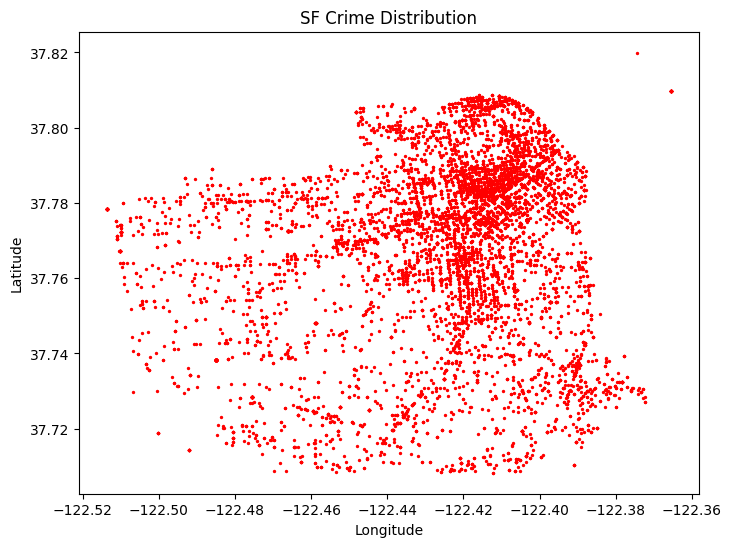

In [21]:
!pip install --upgrade pandas==2.1.0 seaborn==0.12.2 matplotlib==3.8.0

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to Pandas for plotting
pdf = df.select("Longitude", "Latitude").toPandas()
plt.figure(figsize=(8, 6))
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(pdf['Longitude'], pdf['Latitude'], s=2, c='r')
plt.show()

### Clustering with Spark ML

Spark ML requires that features be in a single vector column. We'll use the `VectorAssembler` to
combine the `Longitude` and `Latitude` columns into one features column, and then fit a k-means
model (with k=3, chosen arbitrarily).

In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

df_coor = df.select("Longitude", "Latitude")
vecAssembler = VectorAssembler(inputCols=["Longitude", "Latitude"], outputCol="features")
new_df = vecAssembler.transform(df_coor).select("features")
new_df.show(10, False)

+----------------------------------------+
|features                                |
+----------------------------------------+
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.47869873046875,37.72821044921875] |
|[-122.39410400390625,37.77638244628906] |
|[-122.414306640625,37.800758361816406]  |
|[-122.3958511352539,37.78132247924805]  |
+----------------------------------------+
only showing top 10 rows



In [23]:
# Train a k-means model with k=3 and a fixed seed for reproducibility
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(new_df)

# Print cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Show cluster memberships
transformed = model.transform(new_df)
transformed.show(20, False)

Cluster Centers: 
[-122.41480275   37.78269368]
[-122.40974769   37.73798359]
[-122.4724593    37.75483376]
+----------------------------------------+----------+
|features                                |prediction|
+----------------------------------------+----------+
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.40340423583984,37.775421142578125]|0         |
|[-122.47869873046875,37.72821044921875] |2         |
|[-122.39410400390625,37.77638244628906] |0         |
|[-122.414306640625,37.800758361816406]  |0         |
|[-122.3958511352539,37.78132247924805]  |0         |
|[-122.41181182861328,37.72880172729492] |1         |
|[-122.38874053955078,37.7630500793457]  |0         |
|[-122.40560913085938,37.73243713378906] |1         |
|[-122.43531799316406,37.764

### Visualizing Clustering Results

You can now visualize the clusters (for example, by converting the predictions back to Pandas
and plotting them with different colors). Below is one example:

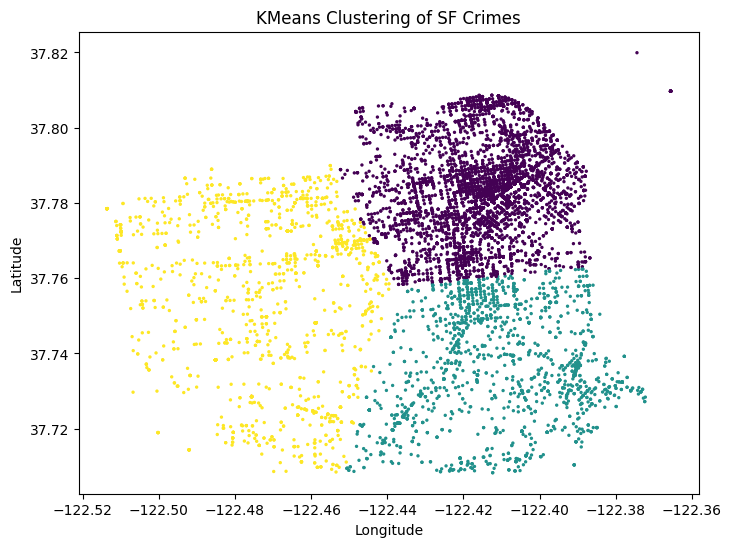

In [24]:
pdf_clusters = transformed.select("features", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.title('KMeans Clustering of SF Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(pdf_clusters['features'].apply(lambda x: x[0]),
            pdf_clusters['features'].apply(lambda x: x[1]),
            c=pdf_clusters['prediction'], cmap='viridis', s=2)
plt.show()